In [1]:
# splicing categories are pairwise (do they need a reference?)
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from venn import venn

from data_loading import (load_annotated_6k_collection,
    load_annotated_gencode_tfs, 
    load_tf_families)

In [2]:
tfs = load_annotated_6k_collection()
tfs_gc = load_annotated_gencode_tfs()
tf_fam = load_tf_families()
from data_loading import load_y2h_isoform_data, load_y1h_pdi_data, load_valid_isoform_clones
from isoform_pairwise_metrics import pairs_of_isoforms_comparison_table
from data_loading import load_m1h_activation_data

m1h = load_m1h_activation_data()


y2h = load_y2h_isoform_data()
y1h = load_y1h_pdi_data()
isoforms = load_valid_isoform_clones()
pairs = pairs_of_isoforms_comparison_table(isoforms=isoforms,
                                           y2h=y2h,
                                           y1h=y1h,
                                           m1h=m1h)
pairs['iso_acc_a'] = pairs['clone_acc_a'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
pairs['iso_acc_b'] = pairs['clone_acc_b'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])

pairs['M1H_a'] = pairs['clone_acc_a'].map(m1h.set_index('clone_acc')[['M1H_rep1', 'M1H_rep2', 'M1H_rep3']].mean(axis=1))
pairs['M1H_b'] = pairs['clone_acc_b'].map(m1h.set_index('clone_acc')[['M1H_rep1', 'M1H_rep2', 'M1H_rep3']].mean(axis=1))
pairs['tf_family'] = pairs['tf_gene_symbol'].map(tf_fam)

reading from cache
reading from cache


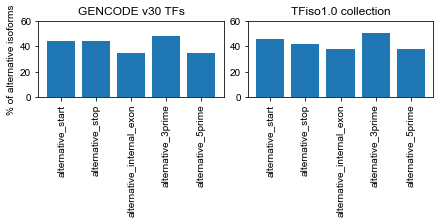

In [3]:
# loop over pairs of isoforms, get fraction of different categories
cats_6k = {k: 0 for k in ['alternative_start',
                           'alternative_stop',
                           'alternative_internal_exon',
                           'alternative_3prime',
                           'alternative_5prime']}
cats_gc = {k: 0 for k in ['alternative_start',
                           'alternative_stop',
                           'alternative_internal_exon',
                           'alternative_3prime',
                           'alternative_5prime']}
n_6k = 0
n_gc = 0
for tf in tfs.values():
    ref_iso = list(sorted(tf.orfs, key=lambda x: len(x.aa_seq)))[-1].name
    for alt_iso in [x.name for x in tf.orfs]:
        if alt_iso == ref_iso:
            continue
        n_6k += 1
        if tf.alternative_start(ref_iso, alt_iso):
            cats_6k['alternative_start'] += 1
        if tf.alternative_stop(ref_iso, alt_iso):
            cats_6k['alternative_stop'] += 1
        if tf.alternative_internal_exon(ref_iso, alt_iso):
            cats_6k['alternative_internal_exon'] += 1
        if tf.alternative_3prime_acceptor(ref_iso, alt_iso):
            cats_6k['alternative_3prime'] += 1
        if tf.alternative_5prime_donor(ref_iso, alt_iso):
            cats_6k['alternative_5prime'] += 1
for tf in tfs_gc.values():
    ref_iso = list(sorted(tf.orfs, key=lambda x: len(x.aa_seq)))[-1].name
    for alt_iso in [x.name for x in tf.orfs]:
        if alt_iso == ref_iso:
            continue
        n_gc += 1
        if tf.alternative_start(ref_iso, alt_iso):
            cats_gc['alternative_start'] += 1
        if tf.alternative_stop(ref_iso, alt_iso):
            cats_gc['alternative_stop'] += 1
        if tf.alternative_internal_exon(ref_iso, alt_iso):
            cats_gc['alternative_internal_exon'] += 1
        if tf.alternative_3prime_acceptor(ref_iso, alt_iso):
            cats_gc['alternative_3prime'] += 1
        if tf.alternative_5prime_donor(ref_iso, alt_iso):
            cats_gc['alternative_5prime'] += 1

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(6, 3)
axs[0].bar(cats_gc.keys(),
           [(x / n_gc) * 100 for x in cats_gc.values()])
axs[1].bar(cats_6k.keys(),
           [(x / n_6k) * 100 for x in cats_6k.values()])
for ax in axs:
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylim(0, 60)
axs[0].set_ylabel('% of alternative isoforms')
axs[0].set_title('GENCODE v30 TFs')
axs[1].set_title('TFiso1.0 collection')
plt.savefig('../figures/splicing-categories-pct_GENCODE-vs-TFiso1_bar.pdf',
            bbox_inches='tight')
plt.show()

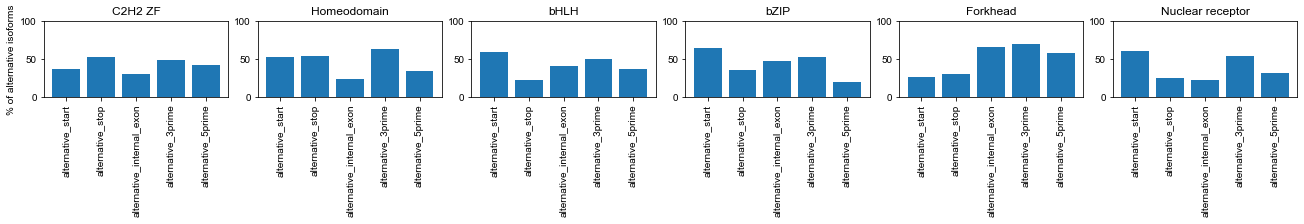

In [4]:
families = ['C2H2 ZF', 'Homeodomain', 'bHLH', 'bZIP', 'Forkhead', 'Nuclear receptor']
fig, axs = plt.subplots(1, len(families))
fig.set_size_inches(3 * len(families), 3)
for family, ax in zip(families, axs):
    cats_6k = {k: 0 for k in ['alternative_start',
                            'alternative_stop',
                            'alternative_internal_exon',
                            'alternative_3prime',
                            'alternative_5prime']}
    n_6k = 0
    for tf in tfs.values():
        if tf_fam[tf.name] != family:
            continue
        ref_iso = list(sorted(tf.orfs, key=lambda x: len(x.aa_seq)))[-1].name
        for alt_iso in [x.name for x in tf.orfs]:
            if alt_iso == ref_iso:
                continue
            n_6k += 1
            if tf.alternative_start(ref_iso, alt_iso):
                cats_6k['alternative_start'] += 1
            if tf.alternative_stop(ref_iso, alt_iso):
                cats_6k['alternative_stop'] += 1
            if tf.alternative_internal_exon(ref_iso, alt_iso):
                cats_6k['alternative_internal_exon'] += 1
            if tf.alternative_3prime_acceptor(ref_iso, alt_iso):
                cats_6k['alternative_3prime'] += 1
            if tf.alternative_5prime_donor(ref_iso, alt_iso):
                cats_6k['alternative_5prime'] += 1
    ax.bar(cats_6k.keys(),
           [(x / n_6k) * 100 for x in cats_6k.values()])
    ax.set_title(family)
for ax in axs:
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylim(0, 100)
axs[0].set_ylabel('% of alternative isoforms')
plt.savefig('../figures/splicing-categories-pct_TFiso1_by-TF-family_bar.pdf',
            bbox_inches='tight')

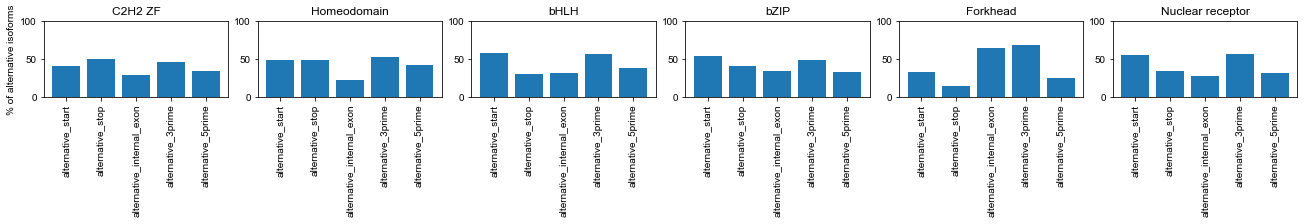

In [5]:
families = ['C2H2 ZF', 'Homeodomain', 'bHLH', 'bZIP', 'Forkhead', 'Nuclear receptor']
fig, axs = plt.subplots(1, len(families))
fig.set_size_inches(3 * len(families), 3)
for family, ax in zip(families, axs):
    cats_6k = {k: 0 for k in ['alternative_start',
                            'alternative_stop',
                            'alternative_internal_exon',
                            'alternative_3prime',
                            'alternative_5prime']}
    n_6k = 0
    for tf in tfs_gc.values():
        if tf.name not in tf_fam or tf_fam[tf.name] != family:
            continue
        ref_iso = list(sorted(tf.orfs, key=lambda x: len(x.aa_seq)))[-1].name
        for alt_iso in [x.name for x in tf.orfs]:
            if alt_iso == ref_iso:
                continue
            n_6k += 1
            if tf.alternative_start(ref_iso, alt_iso):
                cats_6k['alternative_start'] += 1
            if tf.alternative_stop(ref_iso, alt_iso):
                cats_6k['alternative_stop'] += 1
            if tf.alternative_internal_exon(ref_iso, alt_iso):
                cats_6k['alternative_internal_exon'] += 1
            if tf.alternative_3prime_acceptor(ref_iso, alt_iso):
                cats_6k['alternative_3prime'] += 1
            if tf.alternative_5prime_donor(ref_iso, alt_iso):
                cats_6k['alternative_5prime'] += 1
    ax.bar(cats_6k.keys(),
           [(x / n_6k) * 100 for x in cats_6k.values()])
    ax.set_title(family)
for ax in axs:
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylim(0, 100)
axs[0].set_ylabel('% of alternative isoforms')
plt.savefig('../figures/splicing-categories-pct_Gencode_by-TF-family_bar.pdf',
            bbox_inches='tight')
plt.show()

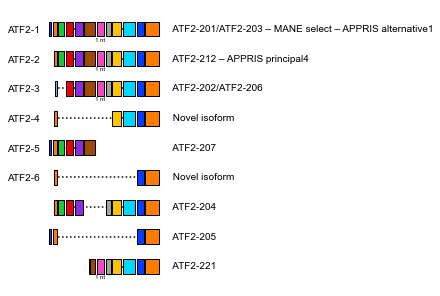

In [6]:
tfs['ATF2'].exon_diagram()

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/IPython/core/events.py:88: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


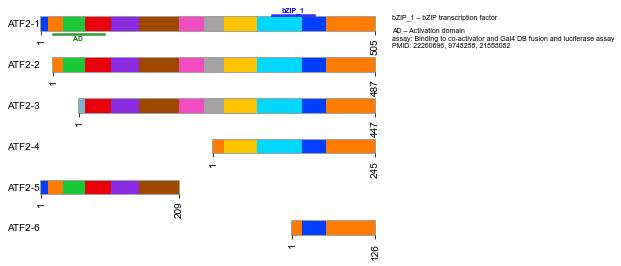

In [7]:
tfs['ATF2'].protein_diagram()

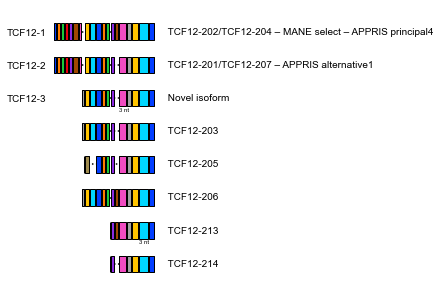

In [8]:
tfs['TCF12'].exon_diagram()

In [9]:
tfs['TCF12'].strand

'+'

In [10]:
# is this true?
tfs['TCF12'].alternative_3prime_acceptor('TCF12-2', 'TCF12-3')

True

In [11]:
cats = {k: set() for k in ['alternative_start',
                           'alternative_stop',
                           'alternative_internal_exon',
                           'alternative_3prime',
                           'alternative_5prime']}
for tf in tfs.values():
    ref_iso = tf.orfs[0].name
    for alt_iso in [x.name for x in tf.orfs[1:]]:
        if tf.alternative_start(ref_iso, alt_iso):
            cats['alternative_start'].add((ref_iso, alt_iso))
        if tf.alternative_stop(ref_iso, alt_iso):
            cats['alternative_stop'].add((ref_iso, alt_iso))
        if tf.alternative_internal_exon(ref_iso, alt_iso):
            cats['alternative_internal_exon'].add((ref_iso, alt_iso))
        if tf.alternative_3prime_acceptor(ref_iso, alt_iso):
            cats['alternative_3prime'].add((ref_iso, alt_iso))
        if tf.alternative_5prime_donor(ref_iso, alt_iso):
            cats['alternative_5prime'].add((ref_iso, alt_iso))

In [12]:
for k, v in cats.items():
    print(k, len(v))

alternative_start 463
alternative_stop 458
alternative_internal_exon 377
alternative_3prime 536
alternative_5prime 403


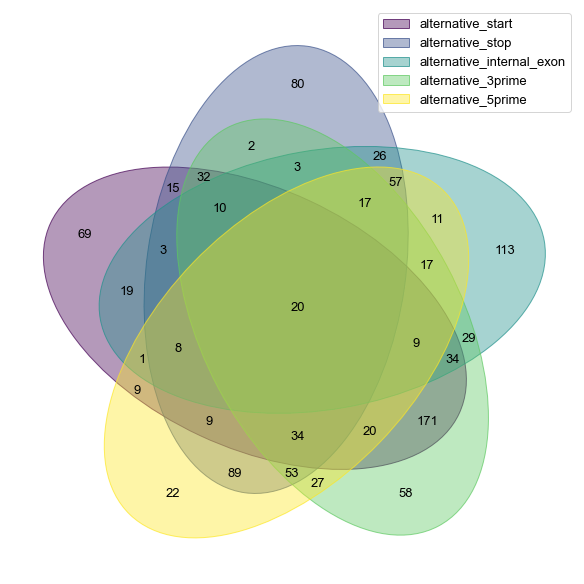

In [13]:
venn(cats)
plt.savefig('../figures/splice-cat_venn.pdf',
            bbox_inches='tight')

In [14]:
# what are the alt. stops that don't have other cats???
cats['alternative_stop'].difference(set.union(*(v for k, v in cats.items() if k != 'alternative_stop')))

{('AEBP2-2', 'AEBP2-207'),
 ('ATF3-1', 'ATF3-2'),
 ('CREM-1', 'CREM-201'),
 ('ESR2-1', 'ESR2-2'),
 ('ESR2-1', 'ESR2-202'),
 ('ESR2-1', 'ESR2-206'),
 ('ESR2-1', 'ESR2-212'),
 ('ETV7-1', 'ETV7-201'),
 ('FOXP2-1', 'FOXP2-10'),
 ('GRHL3-1', 'GRHL3-3'),
 ('HSFY1-1', 'HSFY1-2'),
 ('KLF12-1', 'KLF12-2'),
 ('MAX-1', 'MAX-216'),
 ('MAX-1', 'MAX-5'),
 ('MAZ-2', 'MAZ-212'),
 ('MEIS2-1', 'MEIS2-206'),
 ('MITF-2', 'MITF-3'),
 ('NKX2-5-1', 'NKX2-5-2'),
 ('NKX2-5-1', 'NKX2-5-204'),
 ('NR3C1-1', 'NR3C1-205'),
 ('PATZ1-1', 'PATZ1-2'),
 ('PBX1-1', 'PBX1-209'),
 ('PBX1-1', 'PBX1-222'),
 ('PRDM5-1', 'PRDM5-3'),
 ('PRRX1-1', 'PRRX1-2'),
 ('RFX3-2', 'RFX3-203'),
 ('RORC-1', 'RORC-4'),
 ('RUNX1-1', 'RUNX1-203'),
 ('SMAD4-1', 'SMAD4-2'),
 ('TBX18-2', 'TBX18-3'),
 ('TCF7L2-1', 'TCF7L2-2'),
 ('THAP6-1', 'THAP6-209'),
 ('TP53-1', 'TP53-204'),
 ('TP53-1', 'TP53-206'),
 ('TP63-1', 'TP63-207'),
 ('TSHZ3-2', 'TSHZ3-201'),
 ('ZBTB25-1', 'ZBTB25-4'),
 ('ZKSCAN7-1', 'ZKSCAN7-201'),
 ('ZNF124-1', 'ZNF124-204'),
 ('ZNF12

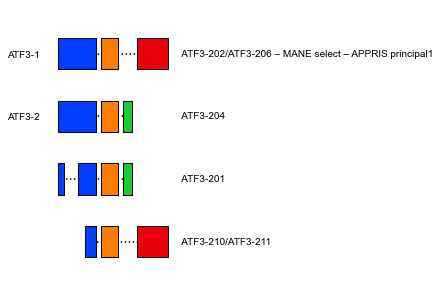

In [15]:
tfs['ATF3'].exon_diagram()

In [16]:
tfs['ATF2'].alternative_3prime_acceptor('ATF2-1', 'ATF2-2')

True

In [17]:
cats.keys()

dict_keys(['alternative_start', 'alternative_stop', 'alternative_internal_exon', 'alternative_3prime', 'alternative_5prime'])

In [18]:
for cat_name, members in cats.items():
    pairs[cat_name] = pairs.apply(lambda x: (x['iso_acc_a'], x['iso_acc_b']) in members,
                                  axis=1)

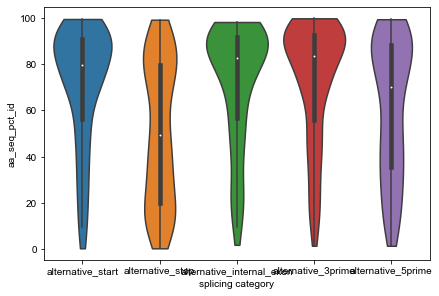

In [19]:
sns.violinplot(data=pd.DataFrame([(cat, v) for cat in cats.keys() 
                       for v in pairs.loc[pairs[cat], 'aa_seq_pct_id'].values], 
                    columns=['splicing category', 'aa_seq_pct_id']),
                x='splicing category',
                y='aa_seq_pct_id',
                cut=0)
plt.show()

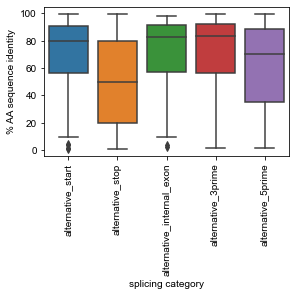

In [20]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
sns.boxplot(data=pd.DataFrame([(cat, v) for cat in cats.keys() 
                       for v in pairs.loc[pairs[cat], 'aa_seq_pct_id'].values], 
                    columns=['splicing category', '% AA sequence identity']),
                x='splicing category',
                y='% AA sequence identity',
                ax=ax)
ax.xaxis.set_tick_params(rotation=90)
plt.savefig('../figures/aa-seq-id_by_splice-cat_box-plot.pdf',
            bbox_inches='tight')
plt.show()

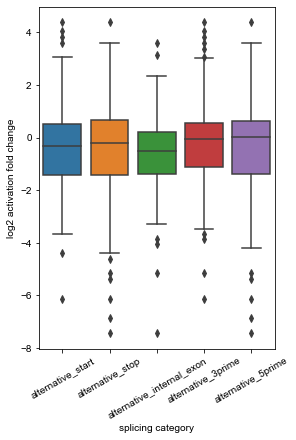

In [21]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 6)
sns.boxplot(data=pd.DataFrame([(cat, v) for cat in cats.keys() 
                       for v in pairs.loc[pairs[cat], 'activation_fold_change'].values], 
                    columns=['splicing category', 'log2 activation fold change']),
                x='splicing category',
                y='log2 activation fold change',
                ax=ax)
ax.xaxis.set_tick_params(rotation=30)
plt.savefig('../figures/m1h-change_by_splice-cat_box-plot.pdf',
            bbox_inches='tight')
plt.show()
plt.show()

<ipython-input-22-db479a142716>:15: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.4, wspace=0.4)


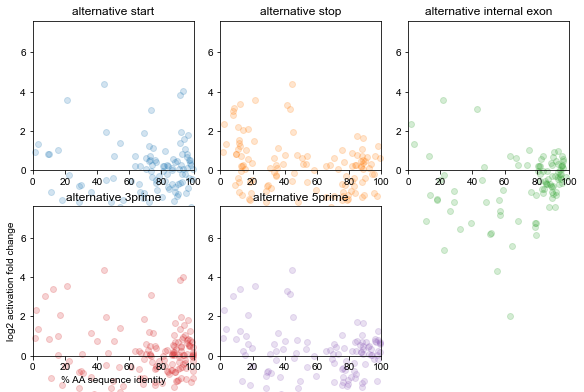

In [22]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(8, 8/3*2)
for i, (cat, ax) in enumerate(zip(cats.keys(), axs.flatten())):
    xy = pairs.loc[pairs[cat], ['aa_seq_pct_id', 'activation_fold_change']].dropna()
    ax.scatter(x=xy['aa_seq_pct_id'], y=xy['activation_fold_change'],
               alpha=0.2,
               clip_on=False,
               color='C' + str(i))
    ax.set_ylim(0, 7.6)
    ax.set_xlim(0, 100)
    ax.set_title(cat.replace('_', ' '))
axs[-1, -1].axis('off')
axs[-1, 0].set_xlabel('% AA sequence identity')
axs[-1, 0].set_ylabel('log2 activation fold change')
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.savefig('../figures/aa-seq_id_vs_m1h-change_by_splice-cat_scatter.pdf',
            bbox_inches='tight')

<ipython-input-23-363193bd9669>:16: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.4, wspace=0.4)


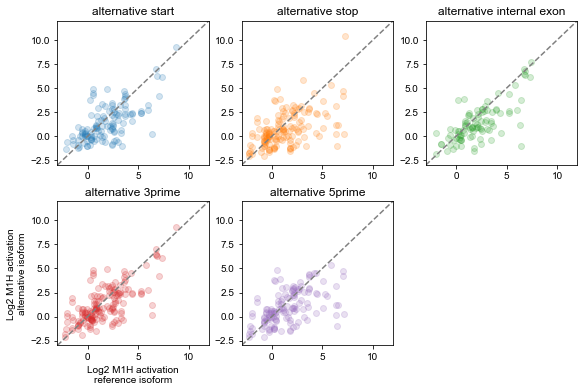

In [23]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(8, 8/3*2)
for i, (cat, ax) in enumerate(zip(cats.keys(), axs.flatten())):
    xy = pairs.loc[pairs[cat], ['M1H_a', 'M1H_b']].dropna()
    ax.scatter(x=xy['M1H_a'], y=xy['M1H_b'],
               alpha=0.2,
               clip_on=False,
               color='C' + str(i))
    ax.plot([-3, 12], [-3, 12], linestyle='--', color='grey')
    ax.set_ylim(-3, 12)
    ax.set_xlim(-3, 12)
    ax.set_title(cat.replace('_', ' '))
axs[-1, -1].axis('off')
axs[-1, 0].set_xlabel('Log2 M1H activation\nreference isoform')
axs[-1, 0].set_ylabel('Log2 M1H activation\nalternative isoform')
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.savefig('../figures/m1h-per-pair_by_splice-cat_scatter.pdf',
            bbox_inches='tight')

<ipython-input-24-7c850706808c>:17: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.4, wspace=0.4)
<ipython-input-24-7c850706808c>:17: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.4, wspace=0.4)
<ipython-input-24-7c850706808c>:17: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.4, wspace=0.4)
<ipython-input-24-7c850706808c>:17: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.4, wspace=0.4)
<ipython-input-24-7c850706808c>:17: UserWarning: This figure was using a layout engine that is incom

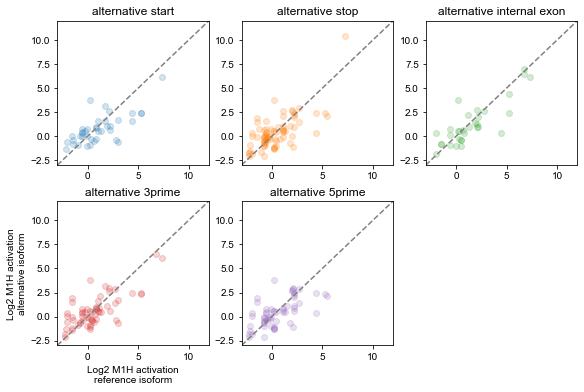

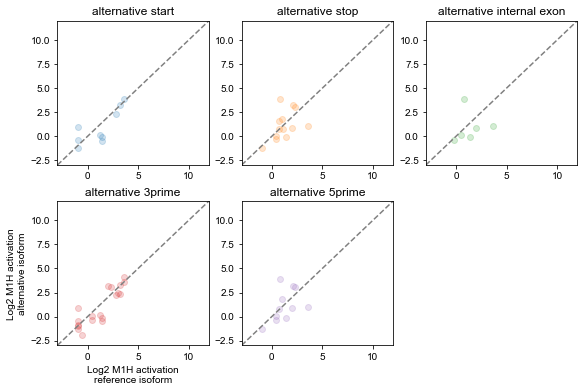

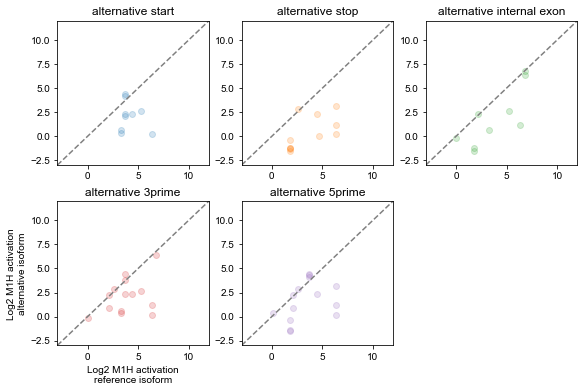

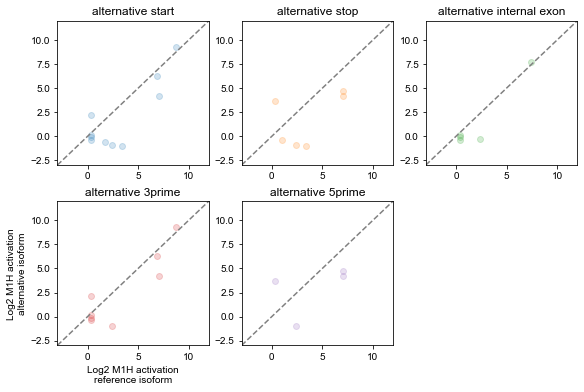

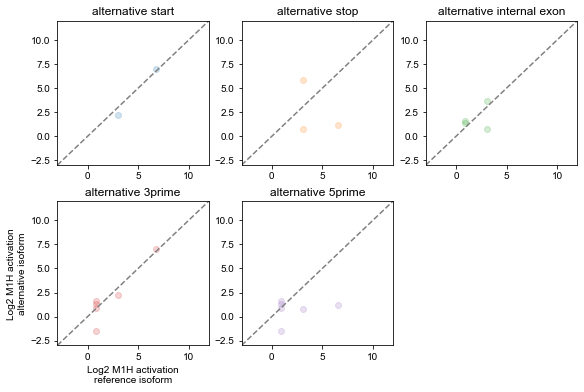

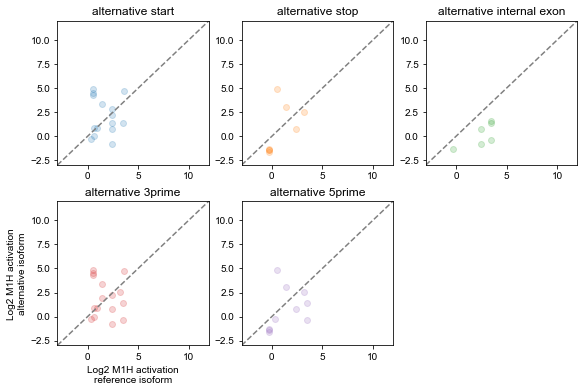

In [24]:
for family in ['C2H2 ZF', 'Homeodomain', 'bHLH', 'bZIP', 'Forkhead', 'Nuclear receptor']:
    fig, axs = plt.subplots(2, 3)
    fig.set_size_inches(8, 8/3*2)
    for i, (cat, ax) in enumerate(zip(cats.keys(), axs.flatten())):
        xy = pairs.loc[pairs[cat] & (pairs['tf_family'] == family), ['M1H_a', 'M1H_b']].dropna()
        ax.scatter(x=xy['M1H_a'], y=xy['M1H_b'],
                alpha=0.2,
                clip_on=False,
                color='C' + str(i))
        ax.plot([-3, 12], [-3, 12], linestyle='--', color='grey')
        ax.set_ylim(-3, 12)
        ax.set_xlim(-3, 12)
        ax.set_title(cat.replace('_', ' '))
    axs[-1, -1].axis('off')
    axs[-1, 0].set_xlabel('Log2 M1H activation\nreference isoform')
    axs[-1, 0].set_ylabel('Log2 M1H activation\nalternative isoform')
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.savefig('../figures/m1h-per-pair_by_splice-cat_scatter_{}.pdf'.format(family),
                bbox_inches='tight')

In [25]:
tf_fam.value_counts().head(10)

C2H2 ZF             747
Homeodomain         196
bHLH                108
Unknown              69
bZIP                 54
Forkhead             49
Nuclear receptor     46
HMG/Sox              30
Ets                  27
T-box                17
Name: DBD, dtype: int64

In [26]:
# look at examples where small change in aa sequence is large change in M1H


# FOXJ2-1	FOXJ2-2	
# TBPL1-1	TBPL1-2	
# NR4A1-1/2/3

pairs.loc[pairs['alternative_3prime']
          & (pairs['activation_fold_change'] > 3.), :].sort_values('aa_seq_pct_id', ascending=False)

,tf_gene_symbol,clone_acc_a,clone_acc_b,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,ppi_n_diff,ppi_delta_n,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpson,pdi_n_diff,pdi_delta_n,m1h_min,m1h_max,activation_fold_change,activation_abs_fold_change,aa_seq_pct_id,iso_acc_a,iso_acc_b,M1H_a,M1H_b,tf_family,alternative_start,alternative_stop,alternative_internal_exon,alternative_3prime,alternative_5prime
pair,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NR4A1|1/5|03A04_NR4A1|2/5|03G05,NR4A1,NR4A1|1/5|03A04,NR4A1|2/5|03G05,2.0,2.0,2.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.495597,4.524734,4.029137,4.029137,93.6,NR4A1-1,NR4A1-2,0.495597,4.524734,Nuclear receptor,True,False,False,True,False
NR4A1|1/5|03A04_NR4A1|3/5|03G02,NR4A1,NR4A1|1/5|03A04,NR4A1|3/5|03G02,2.0,2.0,2.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.495597,4.332042,3.836445,3.836445,91.6,NR4A1-1,NR4A1-3,0.495597,4.332042,Nuclear receptor,True,False,False,True,False
E2F6|1/2|10C02_E2F6|2/2|01A04,E2F6,E2F6|1/2|10C02,E2F6|2/2|01A04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.873302,4.948795,3.075493,3.075493,73.3,E2F6-1,E2F6-2,1.873302,4.948795,E2F,True,False,False,True,False
NR4A1|1/5|03A04_NR4A1|4/5|03A03,NR4A1,NR4A1|1/5|03A04,NR4A1|4/5|03A03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.495597,4.872214,4.376617,4.376617,44.2,NR4A1-1,NR4A1-4,0.495597,4.872214,Nuclear receptor,True,True,False,True,True
ZSCAN18|1/7|09F02_ZSCAN18|2/7|09A01,ZSCAN18,ZSCAN18|1/7|09F02,ZSCAN18|2/7|09A01,10.0,0.0,1.0,1.0,0.0,0.0,10.0,-8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.200202,3.773076,3.572874,3.572874,21.4,ZSCAN18-1,ZSCAN18-2,0.200202,3.773076,C2H2 ZF,True,True,True,True,True
ZNF544|1/7|10A12_ZNF544|5/7|02F06,ZNF544,ZNF544|1/7|10A12,ZNF544|5/7|02F06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.501519,1.880822,3.382341,3.382341,12.4,ZNF544-1,ZNF544-5,-1.501519,1.880822,C2H2 ZF,False,True,False,True,True
ZNF544|1/7|10A12_ZNF544|7/7|02H04,ZNF544,ZNF544|1/7|10A12,ZNF544|7/7|02H04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.501519,1.527333,3.028852,3.028852,7.8,ZNF544-1,ZNF544-7,-1.501519,1.527333,C2H2 ZF,False,True,False,True,True


In [27]:
# scatter of reference isoform vs alternative isoform M1H readout